<a href="https://colab.research.google.com/github/ArunKoundinya/DeepLearning/blob/main/posts/deep-learning-project-msis/AmazonReviews_Part5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Sentiment Analysis - Part 5

The main purpose of this file is to explore different neural network architectures especially sequence based ones.

All Models are being tested on 10K Dataset

Best Model is pickled with 0.1 Million or 1 Lakh dataset.

## Table of Contents
- [1 - Packages](#1)
- [2 - Loading the Dataset](#2)
- [3 - Simple RNN without Embeddings](#3)
- [4 - Simple RNN with Embedding Layer](#4)
- [5 - Simple RNN with Embedding Layer along with reduced vocab size](#5)
- [6 - GRU with Embedding Layer with full vocab size](#6)
- [7 - LSTM with Embedding Layer with full vocab size](#7)
- [8 - Bi-LSTM with Embedding Layerwith full vocab size](#8)
- [9 - Comparision of Validation Set Accuracies](#8)

<a name='1'></a>
## 1 - Loading the Packages

In [ ]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.6 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=9776aecac6ca7fd5bf48eecfc4b50f4494384eb497722422dbf23e773a71bbf4
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

from sklearn.metrics import accuracy_score, classification_report

from pandarallel import pandarallel

<a name='2'></a>
## 2 - Loading the DataSet

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/')

testdata = pd.read_csv('test_data_sample_complete.csv')
traindata = pd.read_csv('train_data_sample_complete.csv')


Mounted at /content/drive


In [ ]:
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
train_data = traindata.sample(n=10000, random_state=42)
test_data = testdata.sample(n=1000, random_state=42)

train_data['class_index'] = train_data['class_index'].map({1:0, 2:1})
test_data['class_index'] = test_data['class_index'].map({1:0, 2:1})

train_data['review_combined_lemma'] = train_data['review_combined_lemma'].fillna('')
test_data['review_combined_lemma'] = test_data['review_combined_lemma'].fillna('')

X_train = train_data.review_combined_lemma
y_train = np.array(train_data.class_index)

X = test_data.review_combined_lemma
y = np.array(test_data.class_index)

tokenizer = Tokenizer(oov_token="<UNK>",)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

X_sequences_train = tokenizer.texts_to_sequences(X_train)

X_sequences = tokenizer.texts_to_sequences(X)

X_train = pad_sequences(X_sequences_train, maxlen=100)
X = pad_sequences(X_sequences, maxlen=100)

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(10000, 100)
(500, 100)
(500, 100)


In [ ]:
train_data['class_index'].value_counts()

class_index
1    5046
0    4954
Name: count, dtype: int64

In [ ]:
vocab_size = len(tokenizer.word_index) + 2

<a name='3'></a>
## 3 - Simple RNN w/o Embeddings

In [ ]:
vocab_size = len(tokenizer.word_index) + 2

model_simplernn = Sequential()
model_simplernn.add(SimpleRNN(100, activation='tanh',input_shape=(100,1)))
model_simplernn.add(Dense(1, activation='sigmoid'))

In [ ]:
model_simplernn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10301 (40.24 KB)
Trainable params: 10301 (40.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_simplernn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historysimplernn = model_simplernn.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_simplernn.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 9ms/step - loss: 0.7128 - accuracy: 0.5160
Test Loss: 0.7127525210380554, Test Accuracy: 0.515999972820282


In [ ]:
from plotnine import *

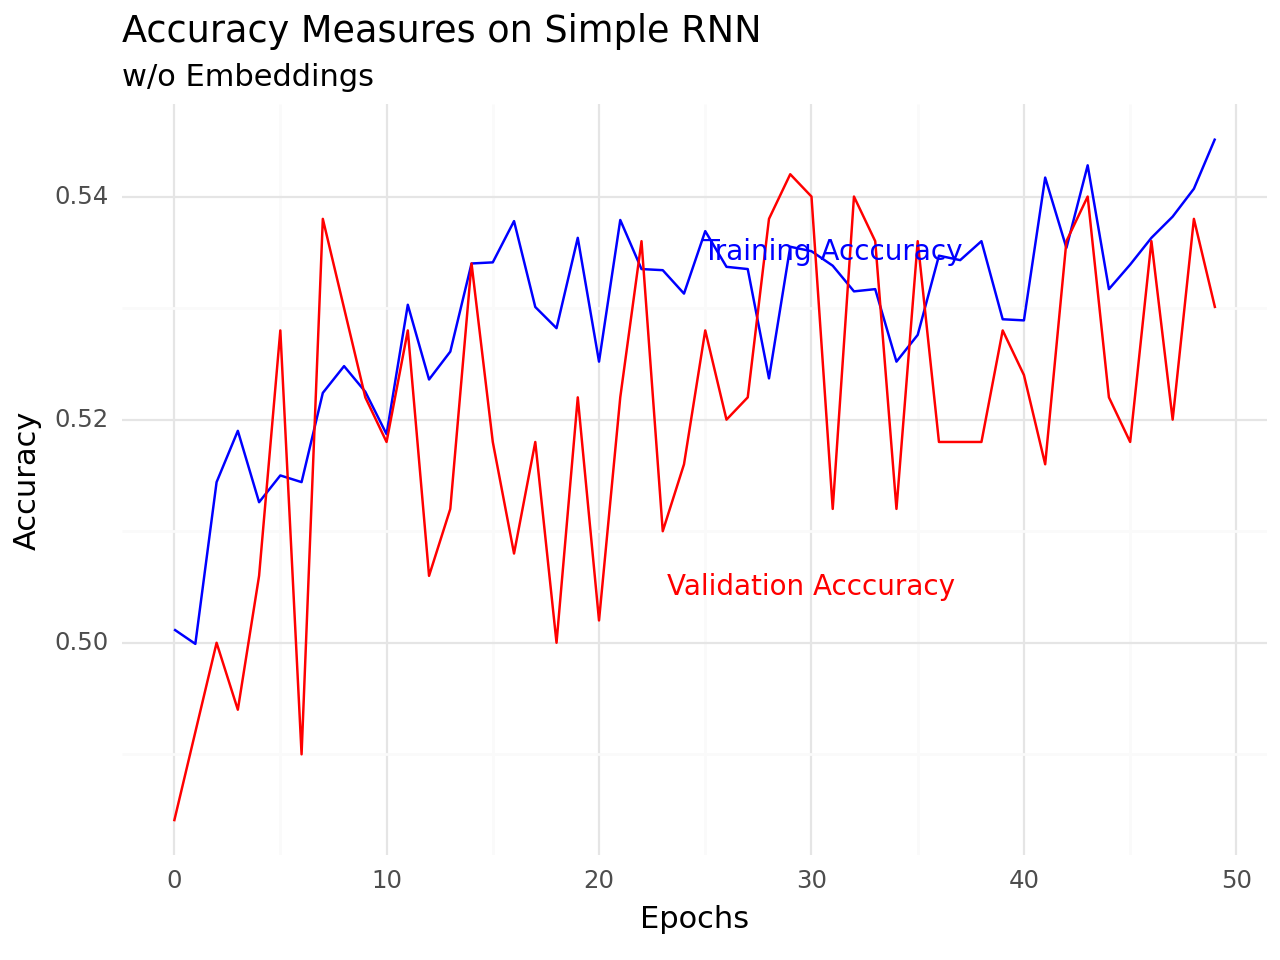

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(historysimplernn.history) >>
 ggplot(aes(x=pd.DataFrame(historysimplernn.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Simple RNN",
       subtitle = "w/o Embeddings") +
  annotate(
      "text",
      x = 31,
      y = 0.535,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 30,
      y = 0.505,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='4'></a>
## 4 - Simple RNN with Embeddings

In [ ]:
vocab_size = len(tokenizer.word_index)
model_simplernn_embed = Sequential()
model_simplernn_embed.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=100))
model_simplernn_embed.add(SimpleRNN(4, activation='tanh'))
model_simplernn_embed.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_simplernn_embed.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            313024    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 52        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 313081 (1.19 MB)
Trainable params: 313081 (1.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_simplernn_embed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historysimplerrn_embed = model_simplernn_embed.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose = 0)

loss, accuracy = model_simplernn_embed.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 8ms/step - loss: 2.1461 - accuracy: 0.5060
Test Loss: 2.1460657119750977, Test Accuracy: 0.5059999823570251


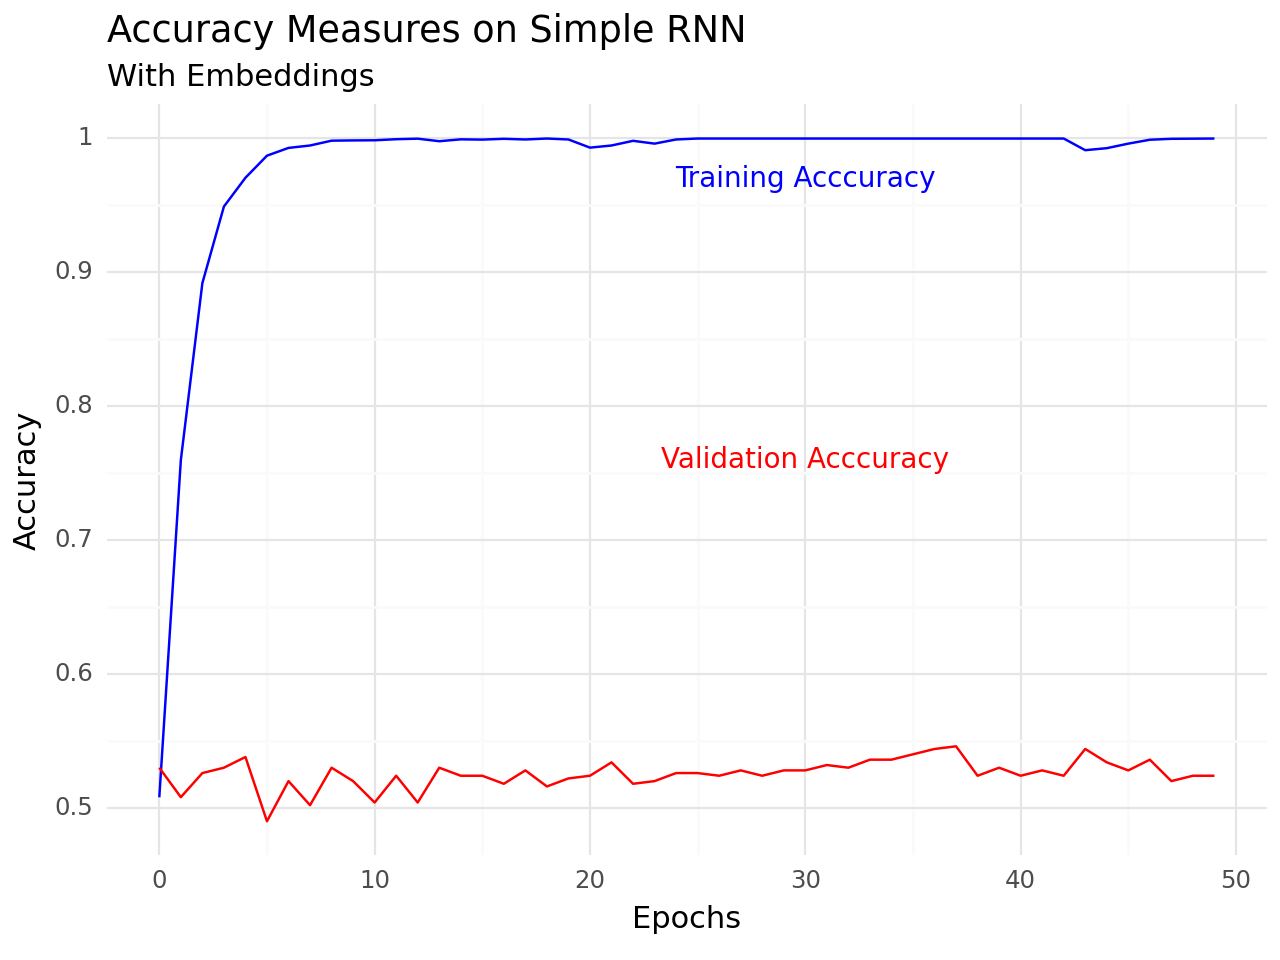

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(historysimplerrn_embed.history) >>
 ggplot(aes(x=pd.DataFrame(historysimplerrn_embed.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Simple RNN",
       subtitle = "With Embeddings") +
  annotate(
      "text",
      x = 30,
      y = 0.97,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 30,
      y = 0.76,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='5'></a>
## 5 - Simple RNN with Embeddings with Reduced Input_Dim i.e.; VocabSize

In [ ]:
model_simplernn_embed_1 = Sequential()
model_simplernn_embed_1.add(Embedding(input_dim=100, output_dim=8, input_length=100))
model_simplernn_embed_1.add(SimpleRNN(100, activation='tanh'))
model_simplernn_embed_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_simplernn_embed_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 8)            800       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               10900     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 11801 (46.10 KB)
Trainable params: 11801 (46.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_simplernn_embed_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

historysimplerrn_embed_1 = model_simplernn_embed_1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose = 0)

loss, accuracy = model_simplernn_embed_1.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 9ms/step - loss: 0.6691 - accuracy: 0.5520
Test Loss: 0.6691163182258606, Test Accuracy: 0.5519999861717224


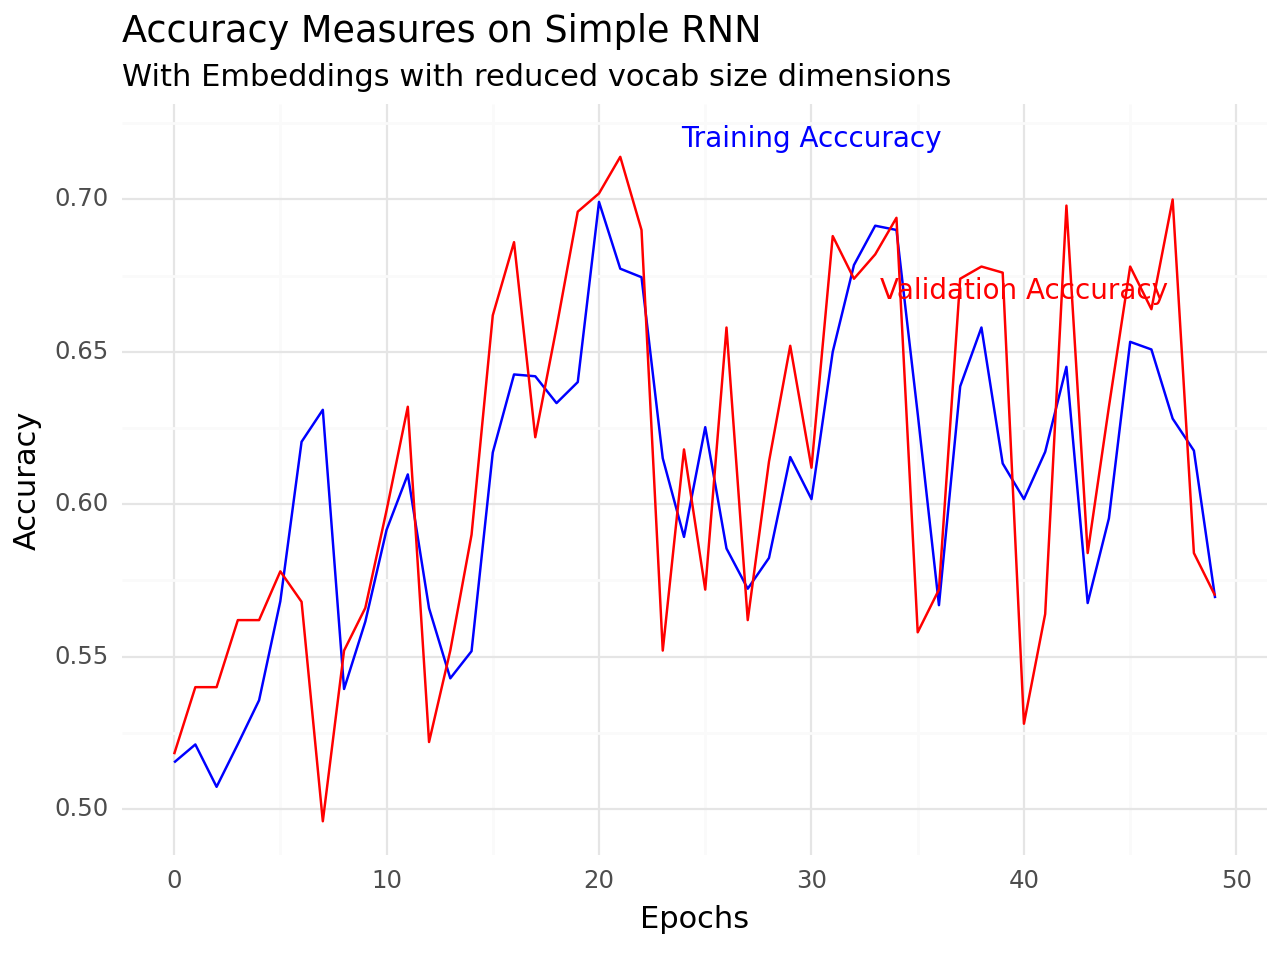

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(historysimplerrn_embed_1.history) >>
 ggplot(aes(x=pd.DataFrame(historysimplerrn_embed_1.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Simple RNN",
       subtitle = "With Embeddings with reduced vocab size dimensions") +
  annotate(
      "text",
      x = 30,
      y = 0.72,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.67,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

In [ ]:
embedding_weights_2 = model_simplernn_embed_1.layers[0].get_weights()[0]
print(embedding_weights_2[0])
print(embedding_weights_2[1])

[-0.05701592 -0.00172939 -0.01085838 -0.04470349  0.08659792 -0.03451009
  0.05999435  0.05736309]
[-0.04299871  0.01049783  0.0390363   0.02932173  0.02287844  0.00434814
 -0.04100406  0.02375711]


In [ ]:
embedding_weights_2.shape

(100, 8)

In [ ]:
embedding_weights = model_simplernn_embed.layers[0].get_weights()[0]
print(embedding_weights[0])
print(embedding_weights[1])

[-0.10668211 -0.06927212  0.05119372  0.01309019  0.08131646 -0.03264609
 -0.03112213  0.07257834]
[ 0.03805954  0.04585579  0.02698555 -0.00836247  0.01085351 -0.01585831
 -0.02024136 -0.03844338]


In [ ]:
embedding_weights.shape

(39128, 8)

<a name='6'></a>
## 6 - GRU with Embeddings with full VocabSize

In [ ]:
model_gru_embed_1 = Sequential()
model_gru_embed_1.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=100))
model_gru_embed_1.add(GRU(100, activation='tanh'))
model_gru_embed_1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_gru_embed_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 8)            313024    
                                                                 
 gru (GRU)                   (None, 100)               33000     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 346125 (1.32 MB)
Trainable params: 346125 (1.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_gru_embed_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_gru_embed = model_gru_embed_1.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_gru_embed_1.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 3ms/step - loss: 1.6417 - accuracy: 0.8060
Test Loss: 1.641699194908142, Test Accuracy: 0.8059999942779541


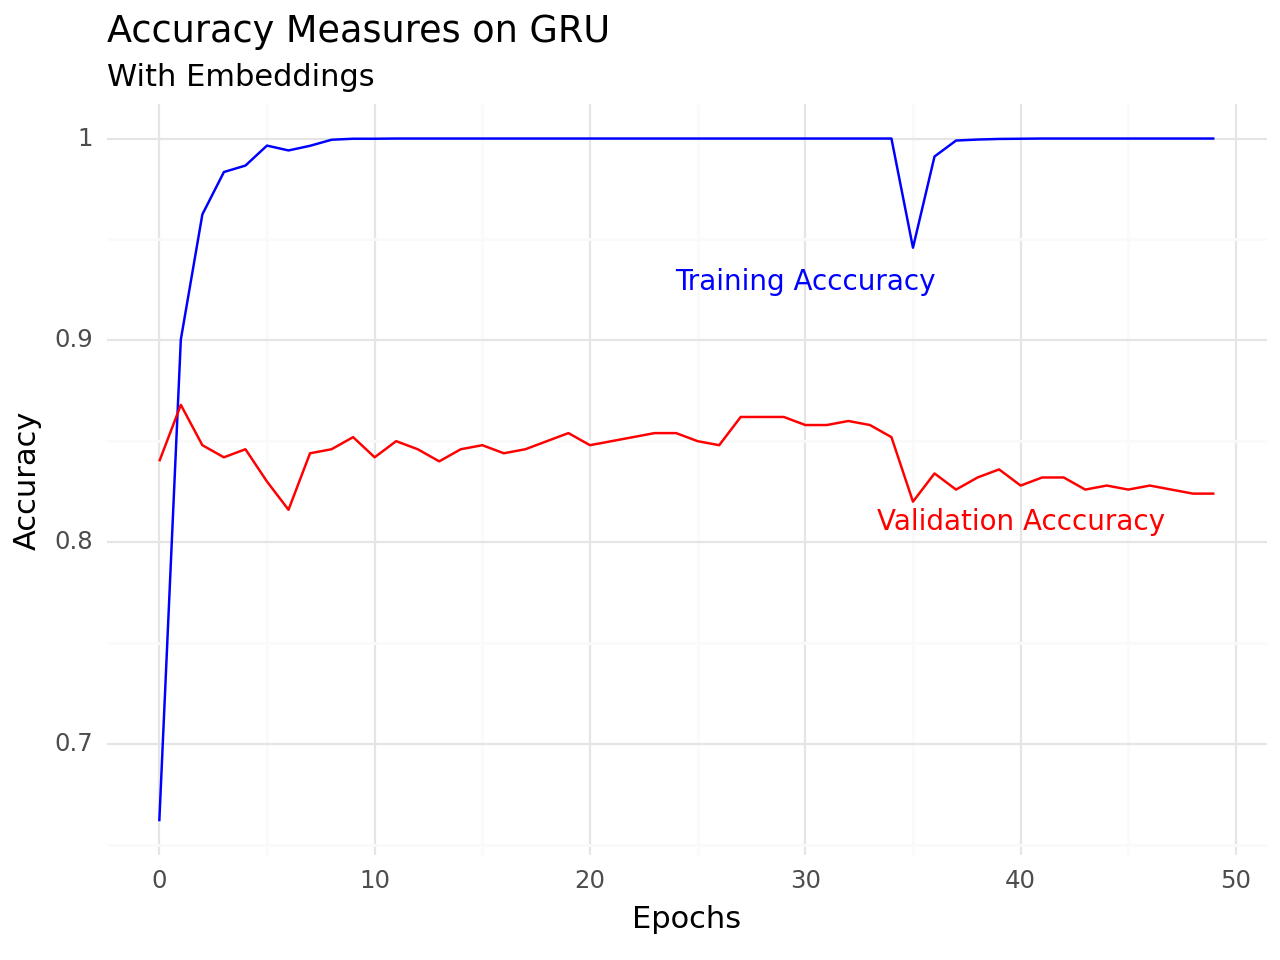

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_gru_embed.history) >>
 ggplot(aes(x=pd.DataFrame(history_gru_embed.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on GRU",
       subtitle = "With Embeddings") +
  annotate(
      "text",
      x = 30,
      y = 0.929,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.81,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='7'></a>
## 7 - LSTM with Embeddings with full VocabSize

In [ ]:
model_lstm_embed = Sequential()
model_lstm_embed.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=100))
model_lstm_embed.add(LSTM(100, activation='tanh'))
model_lstm_embed.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_embed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm_embed = model_lstm_embed.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose = 0)

loss, accuracy = model_lstm_embed.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 3ms/step - loss: 2.2322 - accuracy: 0.7980
Test Loss: 2.2321910858154297, Test Accuracy: 0.7979999780654907


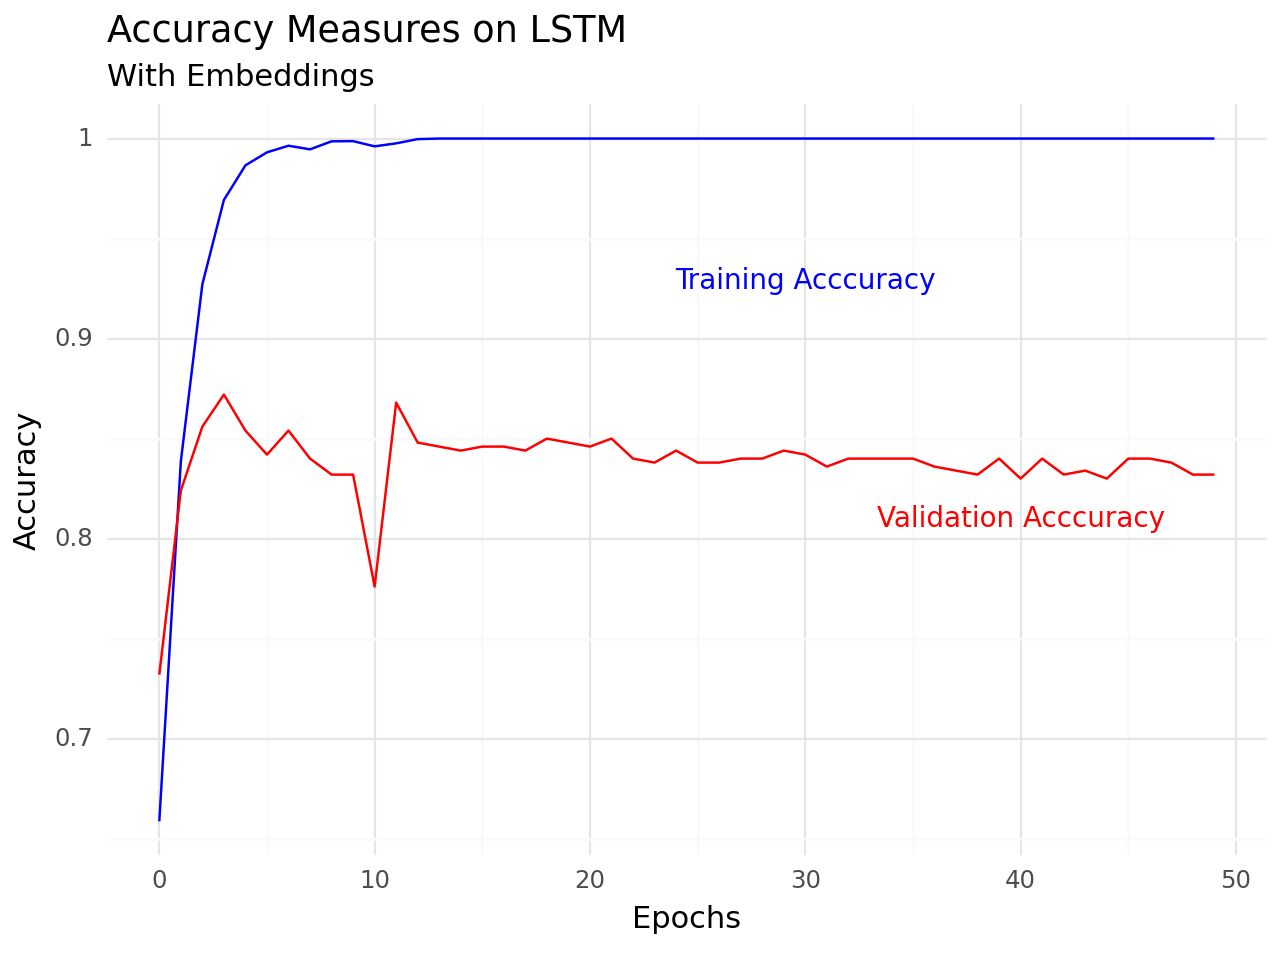

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_lstm_embed.history) >>
 ggplot(aes(x=pd.DataFrame(history_lstm_embed.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on LSTM",
       subtitle = "With Embeddings") +
  annotate(
      "text",
      x = 30,
      y = 0.929,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.81,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='8'></a>
## 8 - Bi-LSTM with Embeddings with full VocabSize

In [ ]:
model_lstm_bi_embed = Sequential()
model_lstm_bi_embed.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=100))
model_lstm_bi_embed.add(Bidirectional(LSTM(100, activation='tanh')))
model_lstm_bi_embed.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed = model_lstm_bi_embed.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=0)

loss, accuracy = model_lstm_bi_embed.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

16/16 [==============================] - 0s 5ms/step - loss: 1.0344 - accuracy: 0.8180
Test Loss: 1.0343992710113525, Test Accuracy: 0.8180000185966492


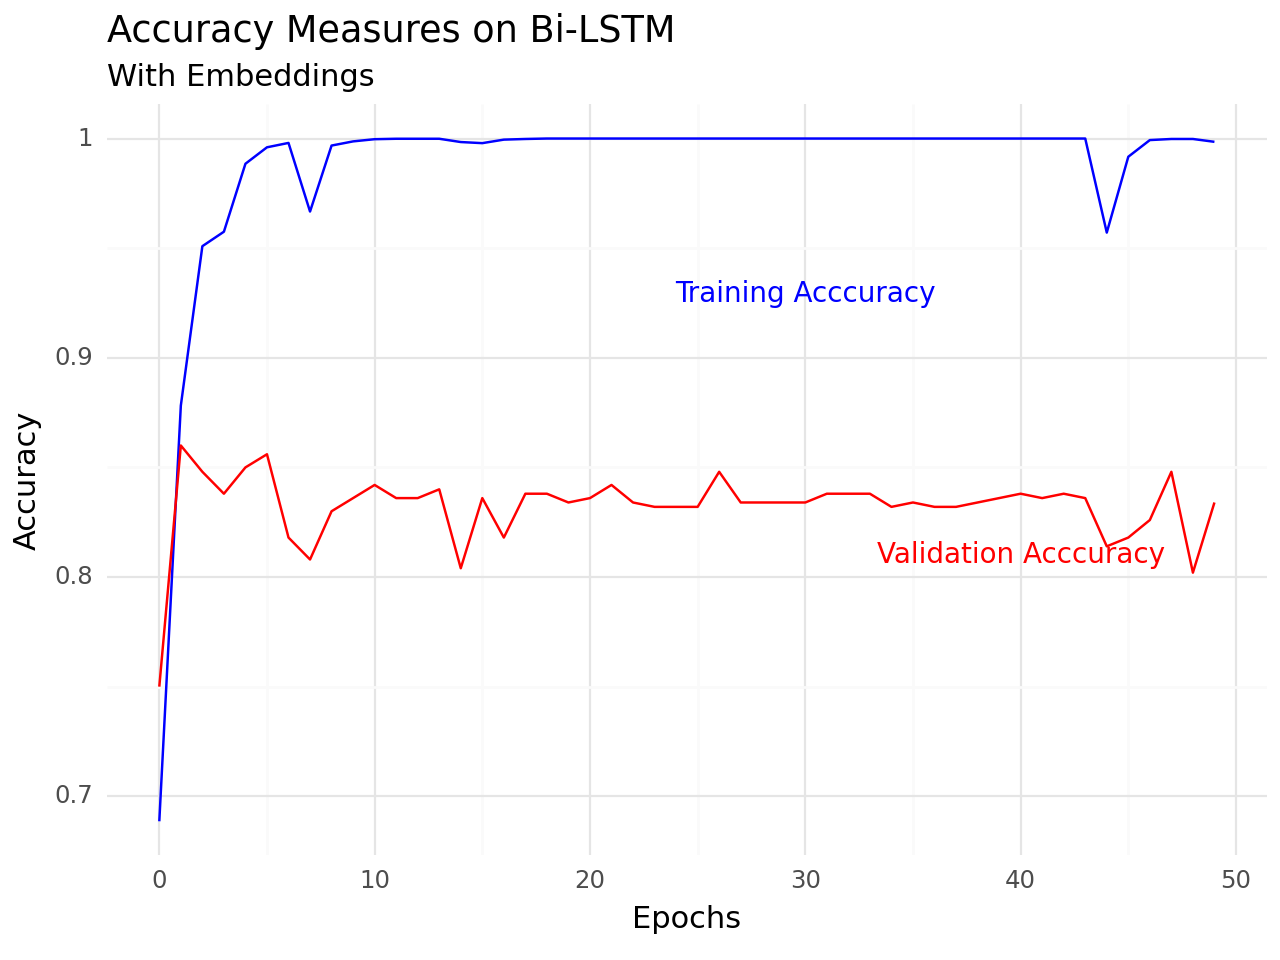

<Figure Size: (640 x 480)>

In [ ]:
( pd.DataFrame(history_bilstm_embed.history) >>
 ggplot(aes(x=pd.DataFrame(history_bilstm_embed.history).index, y='accuracy')) +
 geom_line(color = "blue") +
 geom_line(aes(y='val_accuracy'), color = "red") +
 theme_minimal() +
  labs(x="Epochs", y="Accuracy",
       title= "Accuracy Measures on Bi-LSTM",
       subtitle = "With Embeddings") +
  annotate(
      "text",
      x = 30,
      y = 0.929,
      label = "Training Acccuracy",
      color = "blue",
      size = 10
  ) +
  annotate(
      "text",
      x = 40,
      y = 0.81,
      label = "Validation Acccuracy",
      color = "red",
      size = 10
  )
 )

<a name='9'></a>
## 9 - Comparison of all Validation Set Accuracies

In [ ]:
model_ffnn_4_history = pd.read_csv('model_ffnn_4_history.csv')
history_ffn_embed = pd.read_csv('history_ffn_embed.csv')

In [ ]:
val_accuracy_df = pd.concat([
    pd.DataFrame(history_ffn_embed)['val_accuracy'],
    pd.DataFrame(historysimplernn.history)['val_accuracy'],
    pd.DataFrame(historysimplerrn_embed.history)['val_accuracy'],
    pd.DataFrame(historysimplerrn_embed_1.history)['val_accuracy'],
    pd.DataFrame(history_gru_embed.history)['val_accuracy'],
    pd.DataFrame(history_lstm_embed.history)['val_accuracy'],
    pd.DataFrame(history_bilstm_embed.history)['val_accuracy']
], axis=1)

# Optional: Rename the columns for better identification
val_accuracy_df.columns = [
    'FFN ',
    'SimpleRNN',
    'SimpleRNN with Embedding',
    'SimpleRNN with Reduced Embedding',
    'GRU',
    'LSTM',
    'BiLSTM'
]

# Display the concatenated DataFrame
print(val_accuracy_df)

     FFN   SimpleRNN  SimpleRNN with Embedding  \
0   0.854      0.484                     0.530   
1   0.852      0.492                     0.508   
2   0.856      0.500                     0.526   
3   0.848      0.494                     0.530   
4   0.848      0.506                     0.538   
5   0.848      0.528                     0.490   
6   0.844      0.490                     0.520   
7   0.844      0.538                     0.502   
8   0.844      0.530                     0.530   
9   0.842      0.522                     0.520   
10  0.842      0.518                     0.504   
11  0.840      0.528                     0.524   
12  0.842      0.506                     0.504   
13  0.840      0.512                     0.530   
14  0.840      0.534                     0.524   
15  0.842      0.518                     0.524   
16  0.842      0.508                     0.518   
17  0.842      0.518                     0.528   
18  0.842      0.500                     0.516   


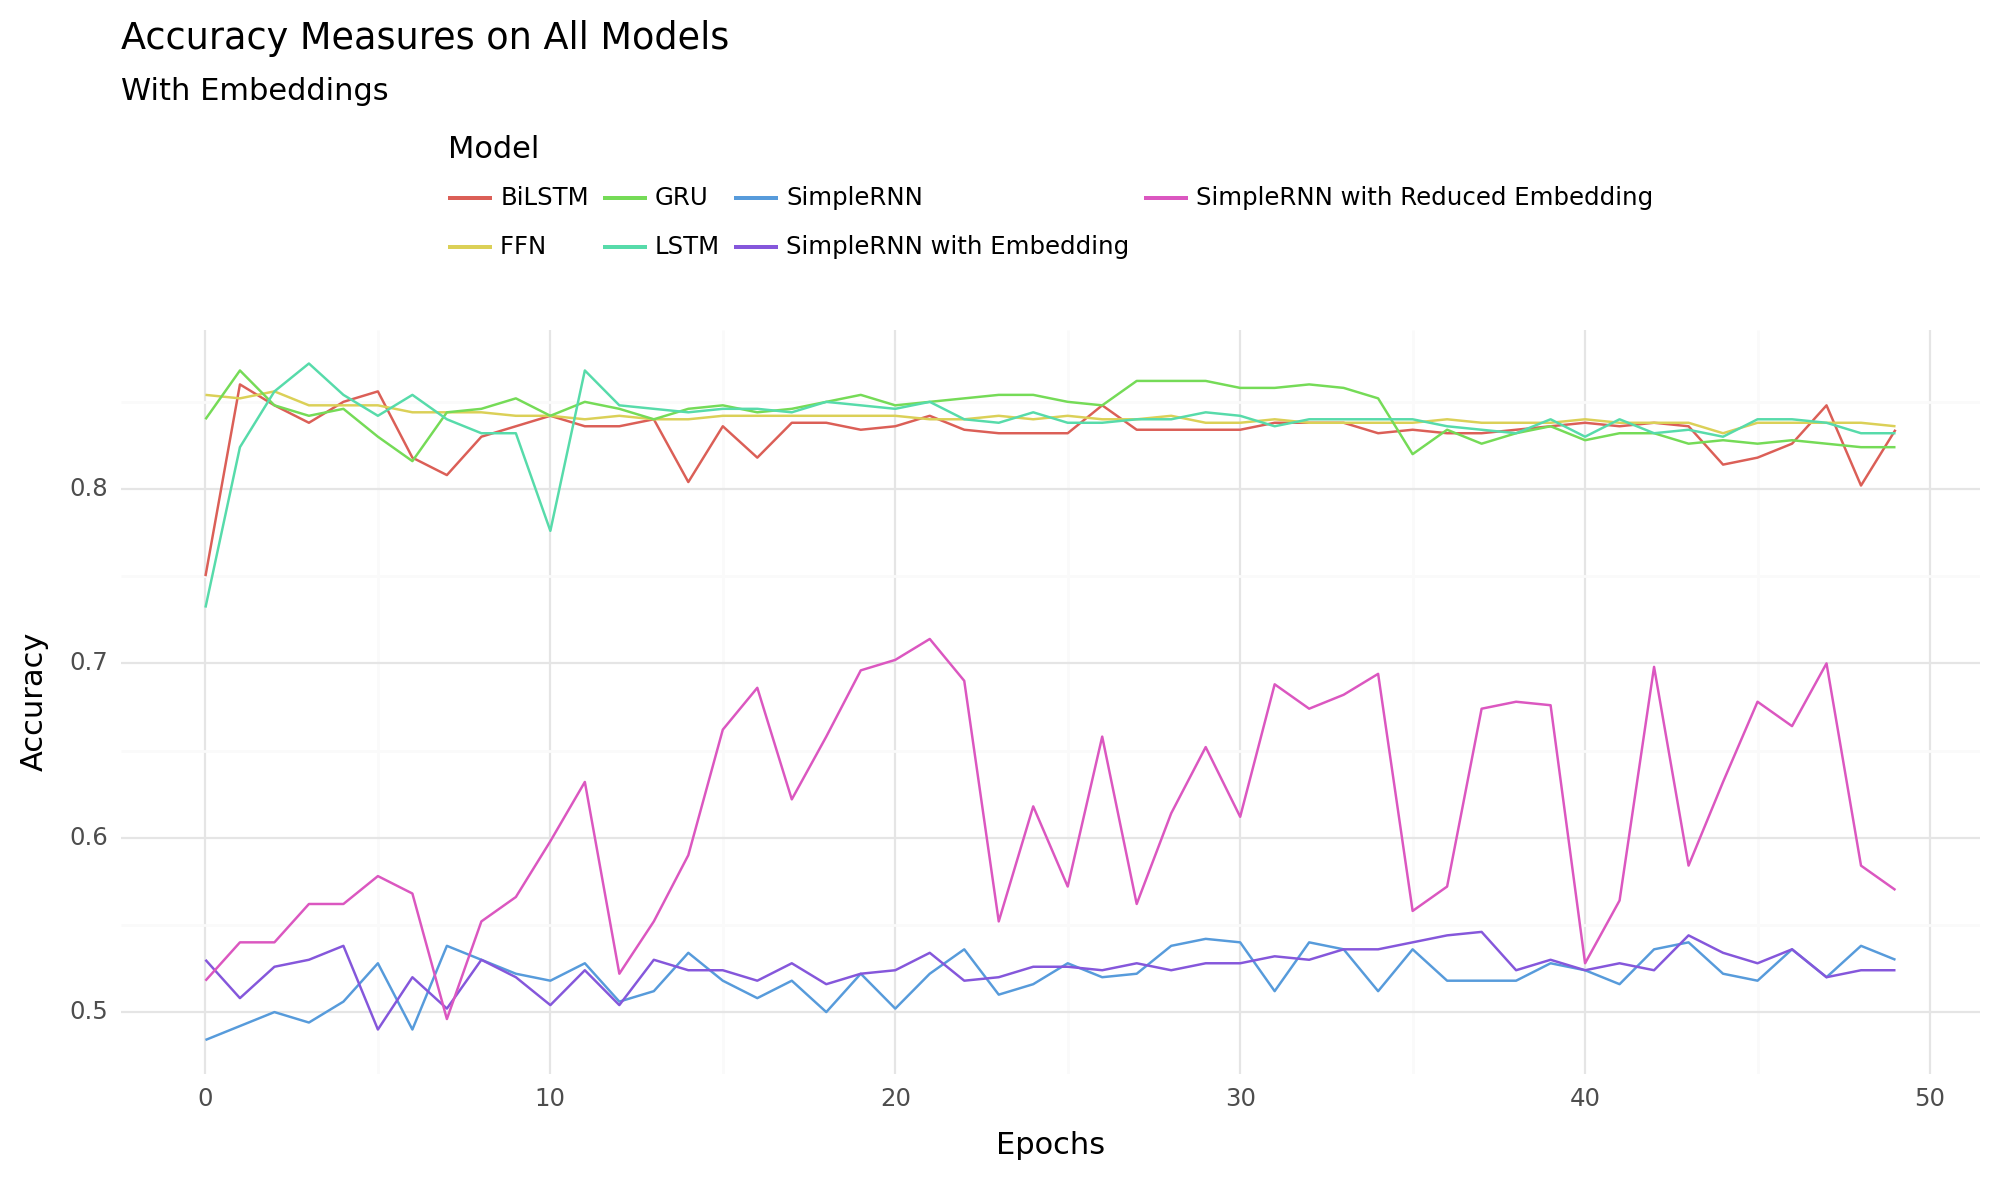

<Figure Size: (1000 x 600)>

In [ ]:
val_accuracy_df_long = val_accuracy_df.reset_index().melt(id_vars='index', var_name='Model', value_name='Accuracy')

(ggplot(val_accuracy_df_long, aes(x='index', y='Accuracy', color='Model')) +
 geom_line() +
 theme_minimal() +
 labs(x="Epochs", y="Accuracy",
      title="Accuracy Measures on All Models",
      subtitle="With Embeddings") +
 theme(legend_position='top', figure_size=(10, 6))  # Increase figure size here
)

In [ ]:
val_accuracy_df.to_csv('val_accuracy_df_Part5.csv', index=False)

Pickling the model

In [ ]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.1 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16673 sha256=2fb79eabfdea108634e7c8818a50bde59627fcda5ebed0667e0e958da22e4d57
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

from sklearn.metrics import accuracy_score, classification_report

from pandarallel import pandarallel

In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/')

testdata = pd.read_csv('test_data_sample_complete.csv')
traindata = pd.read_csv('train_data_sample_complete.csv')


Mounted at /content/drive


In [ ]:
train_data = traindata.sample(n=100000, random_state=42)
test_data = testdata.sample(n=10000, random_state=42)

train_data['class_index'] = train_data['class_index'].map({1:0, 2:1})
test_data['class_index'] = test_data['class_index'].map({1:0, 2:1})

train_data['review_combined_lemma'] = train_data['review_combined_lemma'].fillna('')
test_data['review_combined_lemma'] = test_data['review_combined_lemma'].fillna('')

X_train = train_data.review_combined_lemma
y_train = np.array(train_data.class_index)

X = test_data.review_combined_lemma
y = np.array(test_data.class_index)

tokenizer = Tokenizer(oov_token="<UNK>",)
tokenizer.fit_on_texts(X_train)

tokenizer.word_index['<PAD>'] = 0

X_sequences_train = tokenizer.texts_to_sequences(X_train)

X_sequences = tokenizer.texts_to_sequences(X)

X_train = pad_sequences(X_sequences_train, maxlen=100)
X = pad_sequences(X_sequences, maxlen=100)

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(100000, 100)
(5000, 100)
(5000, 100)


In [ ]:
import pickle
with open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/vocab_dict.pkl', 'wb') as f:
  pickle.dump(tokenizer.word_index, f)


In [ ]:
len(tokenizer.word_index)

180362

In [ ]:
vocab_size = len(tokenizer.word_index) + 2
model_lstm_bi_embed = Sequential()
model_lstm_bi_embed.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=100))
model_lstm_bi_embed.add(Bidirectional(LSTM(100, activation='tanh')))
model_lstm_bi_embed.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model_lstm_bi_embed.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            1442912   
                                                                 
 bidirectional (Bidirection  (None, 200)               87200     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 1530313 (5.84 MB)
Trainable params: 1530313 (5.84 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm_bi_embed.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_bilstm_embed = model_lstm_bi_embed.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_dev, y_dev),verbose=1)

loss, accuracy = model_lstm_bi_embed.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/50
1563/1563 [==============================] - 93s 56ms/step - loss: 0.3261 - accuracy: 0.8584 - val_loss: 0.2586 - val_accuracy: 0.8966
Epoch 2/50
1563/1563 [==============================] - 28s 18ms/step - loss: 0.1854 - accuracy: 0.9308 - val_loss: 0.2617 - val_accuracy: 0.8948
Epoch 3/50
1563/1563 [==============================] - 23s 15ms/step - loss: 0.1287 - accuracy: 0.9552 - val_loss: 0.3074 - val_accuracy: 0.8884
Epoch 4/50
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0900 - accuracy: 0.9697 - val_loss: 0.3500 - val_accuracy: 0.8826
Epoch 5/50
1563/1563 [==============================] - 20s 13ms/step - loss: 0.0641 - accuracy: 0.9793 - val_loss: 0.3856 - val_accuracy: 0.8806
Epoch 6/50
1563/1563 [==============================] - 19s 12ms/step - loss: 0.0470 - accuracy: 0.9852 - val_loss: 0.4357 - val_accuracy: 0.8764
Epoch 7/50
1563/1563 [==============================] - 21s 13ms/step - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.4586 -

In [ ]:
import pickle

with open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/model_lstm_bi_embed.pkl', 'wb') as f:
  pickle.dump(model_lstm_bi_embed, f)


Pickle Loading

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/')


Mounted at /content/drive


In [ ]:
%%writefile app.py
import numpy as np
import pandas as pd
import streamlit as st
import pickle
import warnings
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

model_rfm = pickle.load(open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/best_model_traditional.pkl', 'rb'))
model_bistm = pickle.load(open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/model_lstm_bi_embed.pkl', 'rb'))
vocab_dict = pickle.load(open('/content/drive/My Drive/MSIS/IntroductiontoDeepLearning/Project/vocab_dict.pkl', 'rb'))

cols= ['review_title','review_text']


def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text into words
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Join the words back into a single string
    text = ' '.join(words)
    return text

stop_words = set(stopwords.words('english')) - { 'not', 'no', 'couldn', "couldn't", "wouldn't", "shouldn't", "isn't",
                                                "aren't", "wasn't", "weren't", "don't", "doesn't", "hadn't", "hasn't",
                                                 "won't", "can't", "mightn't","needn't","nor","shouldn","should've","should",
                                                 "weren","wouldn","mustn't","mustn","didn't","didn","doesn","did","does","hadn",
                                                 "hasn","haven't","haven","needn","shan't"}

def process_sentence(sentence):
  list1 = []
  for word in sentence.split():
    if word in vocab_dict:
      list1.append(vocab_dict[word])
    else:
      list1.append(vocab_dict["<UNK>"])
  return list1

def format_examples(data1, vocab_dict, maxlen):
  sequences_data=data1['review_combined_lemma'].apply(process_sentence).tolist()
  padded_sequences_data = pad_sequences(sequences_data, maxlen=maxlen)
  return padded_sequences_data

def main():
    st.title("Sentiment Predictor")
    html_temp = """
    <div style="background:#025246 ;padding:10px">
    <h2 style="color:white;text-align:center;">Sentiment Prediction App </h2>
    </div>
    """
    st.markdown(html_temp, unsafe_allow_html = True)

    model_selected = st.radio('Pick Model:', ['Random Forest','Bi-LSTM with Embedded Layer'])

    review_title = st.text_area('REVIEW TITLE')
    review_text = st.text_area('REVIEW TEXT')
    features = [[review_title,review_text]]

    data = {'review_title': str(review_title),'review_text': str(review_text)}

    df=pd.DataFrame([list(data.values())], columns=cols)

    df['review_combined'] = df['review_title'] + " " + df['review_text']
    df['review_combined_lemma'] = df['review_combined'].apply(preprocess)

    if st.button("Predict"):
        #print(data)

        if model_selected == 'Random Forest':
          prediction = model_rfm.predict(df['review_combined_lemma'].values)
        else:
          X_review_combined_lemma = format_examples(df, vocab_dict, 100)
          prediction = model_bistm.predict(X_review_combined_lemma).astype(float)

        if float(prediction) > 0.5:
            st.success('Postive!!')
        else:
            st.success('Negative!!')

if __name__=='__main__':
    main()

Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

35.201.245.212


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.201.245.212:8501

npx: installed 22 in 3.21s
your url is: https://smart-swans-guess.loca.lt
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
2024-04-27 21:13:14.634597: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 21:13:14.634647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 21:13:14.636057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.